In [1]:
def save_to_dict(record, dict, field_list):
    if not record is None:
        try:
            # Iterace skrz tuples v seznamu field_list
            for field_tags in field_list:
                # Nazev klice ve slovniku
                dict_key_name =  field_tags[0]

                # Tag pole
                tag =  field_tags[1]

                # Tag podpole
                subfield_tag =  field_tags[2]
                
                # Seznam do ktereho pridame hodnoty a nasledne pridame do slovniku
                dict_add_list = []
                
                # Iterace pres vsechna pole s tagem 'tag'
                for field in record.get_fields(tag):
                    
                    # Pokud pole nema zadna podpole, pridame cele pole do listu dict_add_list
                    if subfield_tag is None:
                        dict_add_list.append(str(field))
                    
                    # Pokud subtag je instance slice, tedy to znamena, ze chceme jen nejakou cast pole, ktera neni definovana subpolem,
                    # pridame cast pole do slovniku dict_add_list    
                    elif isinstance(subfield_tag, slice):
                        dict_add_list.append(str(field) [subfield_tag])     
                    
                    # Pokud pole obsahuje podpole, pridame do slovniku dict_add_list jen podpole
                    elif '$'+subfield_tag in str(field):  
                        dict_add_list.append(str(field[subfield_tag]))

                # Do klice z tuplu pridame cely seznam dict_add_list         
                dict[dict_key_name].append(dict_add_list)
        except Exception as error:
            print("Exception: " + type(error).__name__)  
            print("964 Field: " + str(record.get_fields('964')))  
            print("LDR: " + str(record.leader))   
    return dict 

In [54]:
import pandas as pd
import re 
from pymarc import MARCReader

# 'data/csv/ucla_B.csv'
# 'data/csv/ucla_ret.csv'
# 'data/csv/ucla_smz.csv'
# 'data/csv/ucla_int.csv'
# 'data/csv/ucla_cle.csv'
# 'data/csv/ucla_trl.csv'

# Cesta k marcovemu dokumentu
database = 'data/ucla/ucla_int.mrc'

# Z cesty vytahneme typ databaze
pattern = r"data/ucla/ucla_(.*?)\.mrc"

# Find the substring using regex
database_type = re.search(pattern, database).group(1)

out = 'data/csv/out_{}.csv'.format(database_type)

with open(database, 'rb') as data:
    reader = MARCReader(data)
    # Seznam poli, ktere si chceme ulozit
    field_list = [('title', '245', 'a'),
                ('author', '100', 'a'),
                ('author code', '100', '7'),
                # Rok je schovany v poli 008 na 13. az 16. miste, 
                # proto vyuzijeme funkci slice
                ('year', '008', slice(13,17, None)),
                ('figures', '600', 'a'),
                ('description', '650', 'a'),
                ('genre', '655', 'a'),
                ('magazine', '773', 't')]
    dict = {}
    for t in field_list:
        dict_key_name = t[0]
        dict[dict_key_name] = []
    for record in reader:
        dict = save_to_dict(record, dict, field_list)
    df = pd.DataFrame.from_dict(dict)

    # U jmen si chceme ulozit jmeno a prijmeni bez koncove carky ',', ktera je na konci stringu
    df['figures'] = df['figures'].apply(lambda x: [y[:y.rfind(',')] if isinstance(y, str) and len(y) > 0 else y for y in x]) 
    df['author'] = df['author'].apply(lambda x: [y[:y.rfind(',')] if isinstance(y, str) and len(y) > 0 else y for y in x])  

    # Aby se nam list hodnot lepe ukladal, vytvorime z listu jeden string a jednotlive elementy spojime strednikem ';' 
    for column in df.columns:
        df[column] = df[column].apply(lambda x: ';'.join(x))
    df.to_csv(out, encoding = 'utf8', sep = ",") 

### Nacteni dat

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

out = 'data/csv/out_{}.csv'.format(database_type)

# Cesta k nasim datum
csv_data = out

# Nacteni dat
df = pd.read_csv(csv_data, delimiter=',')
# Odstraneni zbytecneho sloupce
df = df.drop(['Unnamed: 0'], axis = 1)

for column in df.columns:
    if df[column].dtype != 'int64':   
        # Hodnoty spojene v jeden string zpatky rozdelime do listu, aby se nam s nim lepe pracovalo
        df[column] = df[column].apply(lambda x: x.split(';') if isinstance(x, str)  else [])


In [4]:
# Funkce, ktera najde unikatni elementy z DataFrame sloupce.
# Predpoklada, ze vsechny elementy jsou v listu a muze jich byt vice
def find_unique(lst):
    unique_list = []
    for element_list in lst:
        for element in element_list:
            if element not in unique_list:
                unique_list.append(element)
    return unique_list  

# Funkce na "zplosteni" listu -> ze sloupce DataFramu vytvori jeden list se vsemi elementy 
def flatten_list(strings):
    flattened_list = []
    for item in strings:
        if isinstance(item, str):  # Pokud je element string, pridame ho do seznamu
            flattened_list.append(item)
        else:  # Rekurzivne zavola sebe
            flattened_list.extend(flatten_list(item))
    return flattened_list

In [57]:
import re

# regex patern, ktery najde substring pred zavorkou
# r"^(.*?)\s*(?=\()" <- kulate zavorky
pattern_magazine = r"(.*?)\[" # <- hranate zavory  

# Odstranime misto vydani v zavore (pokud je pritomno)
df['magazine'] = df['magazine'].apply(lambda x: [re.search(pattern_magazine, y).group(1) if re.search(pattern_magazine, y) else y for y in x])

# Zbavime se prebytecnych mezer na zacatku a na konci stringu
df['magazine'] = df['magazine'].apply(lambda x: [y.rstrip() for y in x])

unique_magazine = find_unique(df.magazine)
print(unique_magazine)

['Hospodářské noviny', 'Víkend', 'iHNed.cz', 'iHned.cz', 'Právo', 'Salon', 'Novinky.cz', 'Lidové noviny', 'Lidovky.cz', 'Mladá fronta Dnes', 'iDnes.cz', 'Dobrá adresa', 'In', 'Relax', 'Revolver Revue', 'Bubínek Revolveru', 'Orientace', 'Pátek', 'Styl pro ženy', 'Brněnský deník Rovnost', 'Brněnský deník', 'Magazín Dnes', 'Café', 'Magazín Právo', 'Ona Dnes', 'Čtení na víkend', 'Doma Dnes', 'iN', 'Dům & bydlení', 'HN na víkend', 'Britské listy', 'Kultura & umění', 'Mladá Fronta Dnes', 'HN na víkend. Kultura & umění', 'Praha', 'Prázdniny', 'Na cestách', 'Čtení na léto', 'Kam na víkend', 'Věda a technika', 'Václav Havel', 'Léto 2003', 'Styl', 'Dům a byt', 'Magazín dnes', 'Magaznín Dnes', 'Magazín', 'Magazín MF Dnes', 'Ego!', 'Mladá fronta dnes', 'Příloha pro ženy', 'Kulturní premiéry', 'Kavárna', 'Pátek LN', 'Vítězný květen', 'Kulturní revue', 'Moje hobby', 'Akademie', 'Mimořádná příloha HN', 'Kniha roku 2007', 'Bellevue', 'Kultura', '20 let LN', 'Magazín Víkend', 'Premiéry', 'Orienatce', '

### Zpracovani dat

In [58]:
from collections import Counter 

# Sloupec, ktery chceme zobrazit.
column = 'author'

# Vsechny elementy ve sloupci
all_elements = flatten_list(df[column])

# Spoceteme, v kolika zaznamech se element objevil
counted_elements = Counter(all_elements)

# Najdeme deset nejcastejsich elementu, ktere pak zobrazime
ten_most_common_elements = [item[0] for item in counted_elements.most_common(10)]

# Vsechny casopisy ve sloupci
all_magazines = flatten_list(df.magazine)

# Spocteme, v kolika zaznamech se casopic objevil
counted_magazines = Counter(all_magazines)

# Najdeme deset nejcastejsich casopisu, ktere pak zobrazime
ten_most_common_magazines = [item[0] for item in counted_magazines.most_common(10)]
          

### Vykresleni grafu

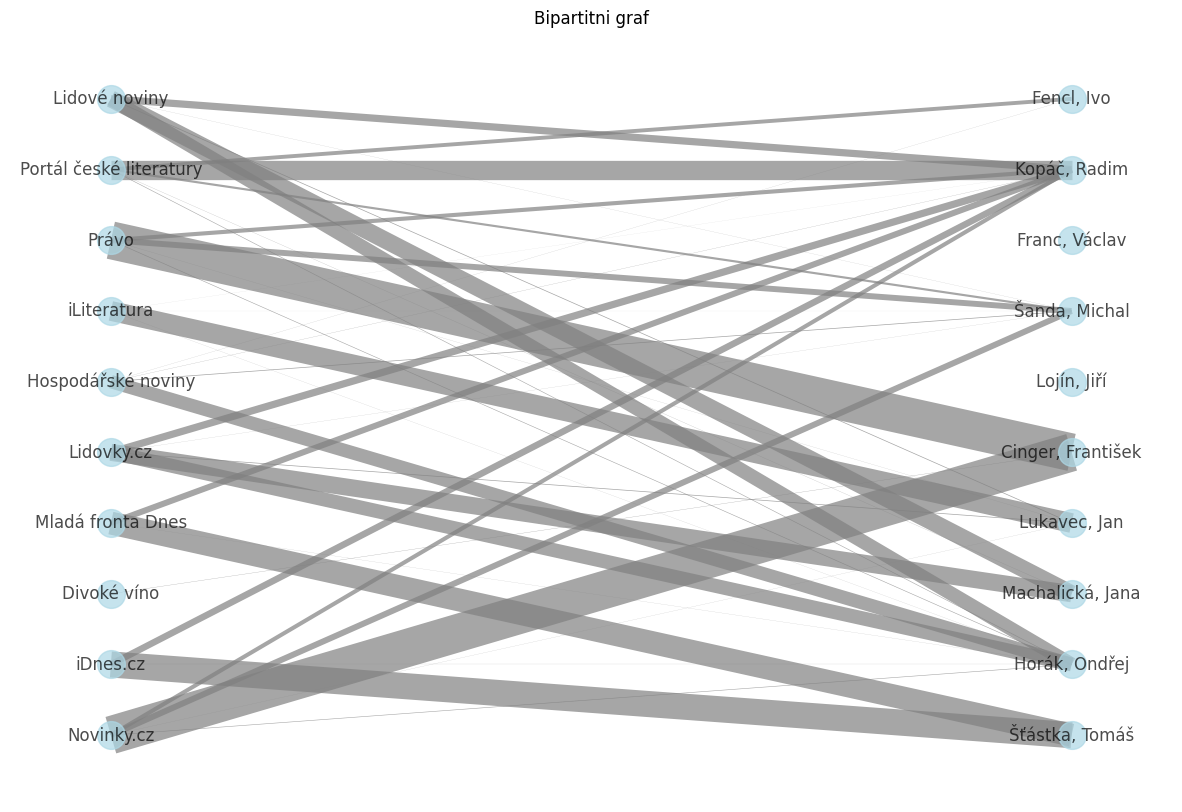

In [59]:
import networkx as nx
import matplotlib.pyplot as plt

# Vytvorime graf
G = nx.Graph()

# Elementy pridame grafu jako uzle
G.add_nodes_from(ten_most_common_elements, bipartite=0)

# Casopisy take pridame jako uzle
G.add_nodes_from(ten_most_common_magazines, bipartite=1)

# Vahy hran. Cim vice clanku v casopisu, tim vyssi vaha.
# Ve vykreslenem grafu pak bude vyssi vaha mit silnejsi caru. 
edge_weights = {}

# Iterujeme pres vsechny clanky
for _,row in df.iterrows():
    for element in row[column]:
        for magazine in row.magazine:
            # Chceme vyselektovat jen desen nejcastejsich elemenu a casopisu
            if element in ten_most_common_elements and magazine in ten_most_common_magazines:
                if (element, magazine) in edge_weights:
                    # Do dictionary hrany pridavame jako tuple 
                    edge_weights[(element, magazine)] += 1
                else:
                    edge_weights[(element, magazine)] = 1

for edge, weight in edge_weights.items():
    G.add_edge(edge[0], edge[1], weight=weight)                

pos = nx.bipartite_layout(G, ten_most_common_magazines)
#pos = nx.spring_layout(G)
plt.figure(figsize=(15, 10))
edge_widths = [0.05 * G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx(G, pos=pos, with_labels=True, node_color='lightblue', node_size=400,
                 width=edge_widths, edge_color='gray', alpha=0.7)
plt.title("Bipartitni graf")
plt.axis("off")
plt.show() 

### Alternativni varianta

In [73]:
from collections import Counter 

# Vsechny casopisy ve sloupci
all_authors = flatten_list(df.author)

# Spocteme, v kolika zaznamech se casopic objevil
counted_authors = Counter(all_authors)

n = 10

# Najdeme nejcastejsi autory, ktere pak zobrazime
most_common_authors = [item[0] for item in counted_authors.most_common(n)]

print(most_common_authors)


# Sloupec, ktery chceme zobrazit.
column = 'magazine'

ind = [True if any([True if author in most_common_authors else False for author in author_list]) else False for author_list in df['author']]


author_elements = df[ind][column]

unique_author_elements = find_unique(author_elements)

print(unique_author_elements)

['Franc, Václav', 'Kopáč, Radim', 'Cinger, František', 'Lojín, Jiří', 'Fencl, Ivo', 'Horák, Ondřej', 'Lukavec, Jan', 'Šťástka, Tomáš', 'Šanda, Michal', 'Machalická, Jana']
['Právo', 'Novinky.cz', 'Dobrá adresa', 'Salon', 'Mladá fronta Dnes', 'iDnes.cz', 'Víkend', 'Lidové noviny', 'Lidovky.cz', 'Orientace', 'Kulturní premiéry', 'Premiéry', 'Kniha roku 2008', 'Hospodářské noviny', 'iHned.cz', 'iHNed.cz', 'In Magazín', 'IN Magazín', 'Boutique', 'Scéna', 'Ego!', 'Půlnoční expres', 'Divoké víno', 'City life', 'H7O', 'iLiteratura', 'U nás', 'Vaše Literatura', 'Kobra', 'Ikaros', 'Kobra silvestrovská', 'Sarden', 'Literarni.cz', 'Čaj', 'Neviditelný pes', 'Literární bašta', 'Britské listy', 'Haló noviny', 'Literatura - Umění - Kultura', 'Sanquis', 'Čítárny', 'Aktuálně.cz', 'Portál české literatury', 'Deník N', 'denikn.cz', 'OKO Kosmasu', 'Host', 'Rum', 'Kruh', 'Centrum Detektivky', '5 let Kobry', '2. Jičínské poetické jaro', '2. Martinská poetická jeseň', 'Silvestrovská Kobra', 'Ravt', '5. Marti

In [61]:
ind_Lojin = [True if any([True if author == 'Lojín, Jiří' else False for author in author_list]) else False for author_list in df['author']]
print(df[ind_Lojin]['magazine'])

16821    [Vaše Literatura]
16850    [Vaše Literatura]
16854    [Vaše Literatura]
16887    [Vaše Literatura]
16932    [Vaše Literatura]
               ...        
57843    [Vaše Literatura]
58137    [Vaše Literatura]
58304    [Vaše Literatura]
58345    [Vaše Literatura]
58692    [Vaše Literatura]
Name: magazine, Length: 537, dtype: object


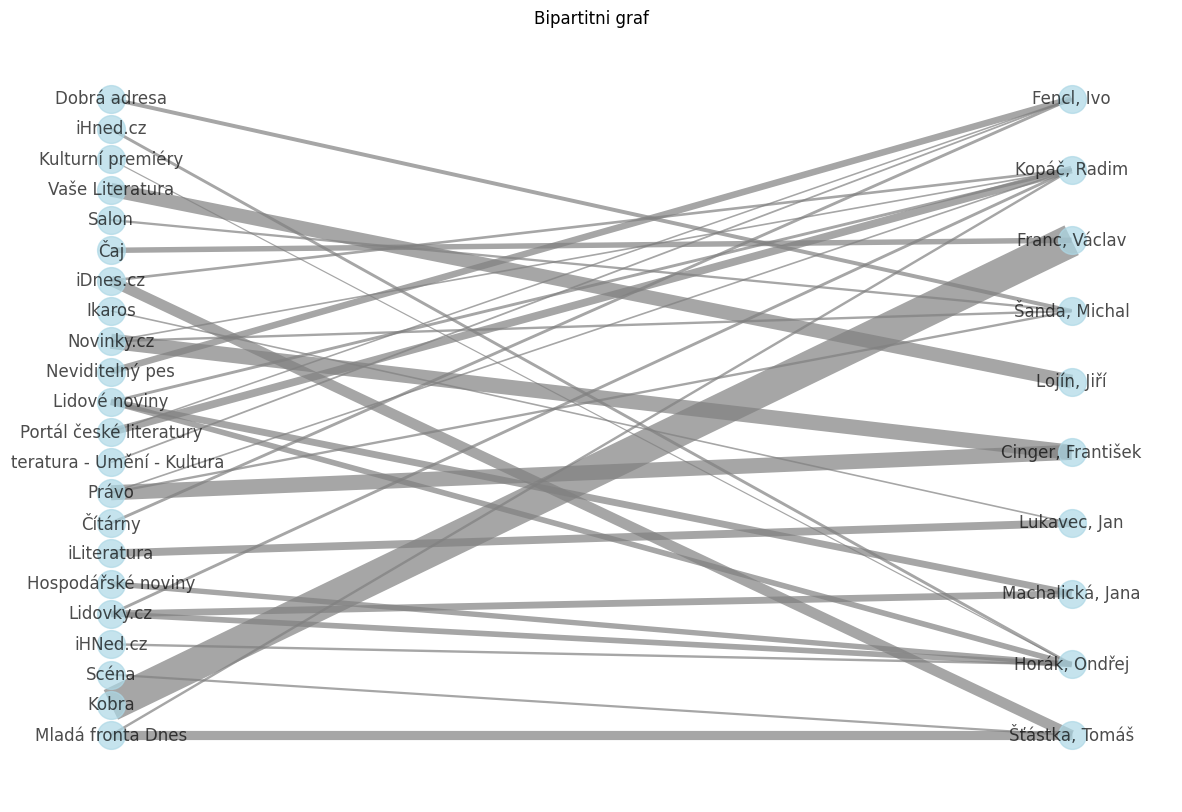

In [75]:
import networkx as nx
import matplotlib.pyplot as plt

# Vytvorime graf
G = nx.Graph()

# Elementy pridame grafu jako uzle
G.add_nodes_from(most_common_authors, bipartite=1)


# Vahy hran. Cim vice clanku v casopisu, tim vyssi vaha.
# Ve vykreslenem grafu pak bude vyssi vaha mit silnejsi caru. 
edge_weights = {}

# Iterujeme pres vsechny clanky
for _,row in df.iterrows():
    for element in row[column]:
        for author in row.author:
            # Chceme vyselektovat jen desen nejcastejsich elemenu a casopisu
            if element in unique_author_elements and author in most_common_authors:
                if  (author, element) in edge_weights:
                    # Do dictionary hrany pridavame jako tuple 
                    edge_weights[(author, element)] += 1
                else:
                    edge_weights[(author, element)] = 1


threshold = 40
left = []

for edge, weight in edge_weights.items():
    if weight>threshold:
        if ~G.has_node(edge[1]):
            left.append(edge[1])
            G.add_node(edge[1], bipartite=0) 
        G.add_edge(edge[0], edge[1], weight=weight)                

pos = nx.bipartite_layout(G, nodes = left)
#pos = nx.spring_layout(G)
plt.figure(figsize=(15, 10))
edge_widths = [0.02 * G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx(G, pos=pos, with_labels=True, node_color='lightblue', node_size=400,
                 width=edge_widths, edge_color='gray', alpha=0.7)
plt.title("Bipartitni graf")
plt.axis("off")
plt.show() 